In [1]:
import os
import time
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb

from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
train = pd.read_csv('./drive/MyDrive/Models/Time Series/train.csv', parse_dates=[0])
test = pd.read_csv('./drive/MyDrive/Models/Time Series/test.csv', parse_dates=[0], index_col='id')

In [4]:
train['Set'] = pd.Series(['train' for x in range(len(train.index))], index=train.index)
test['Set'] = pd.Series(['test' for x in range(len(test.index))], index=test.index)
full_data = pd.concat([train, test])
all_data = full_data[(full_data.store == 2) & (full_data.item == 3)]
all_data = all_data.sales.values.astype(float)
num_test = 100
train_data = all_data[:-num_test]
test_data = all_data[-num_test:]

In [5]:
def create_inout_sequences(input_data, tw):
  inout_seq = []
  L = len(input_data)
  for i in range(L - tw):
    train_seq = input_data[i:i+tw]
    train_label = input_data[i+tw:i+tw+1]
    inout_seq.append((train_seq, train_label))
  return inout_seq

def get_items_tuples(store = 1, tw = 5, input_data = full_data[full_data.Set == 'train']):
  inout_seq = []
  var = input_data[(input_data.store == store)].drop('Set', axis = 1)
  var = torch.FloatTensor([var[var.date == x].sales for x in np.unique(var.date)])
  L = len(var)
  print(L)
  for i in tqdm(range(L - tw)):
    train_seq = var[i:i+tw,:]
    train_label = var[i+tw:i+tw+1,:]
    inout_seq.append((train_seq, train_label))
  return inout_seq


In [12]:
scaler = MinMaxScaler()
train_data_norm = scaler.fit_transform(train_data.reshape(-1,1))
train_data_norm = torch.FloatTensor(train_data_norm).view(-1)

store = 1
TRAIN_WINDOW = 50
# train_inout_seq = create_inout_sequences(train_data_norm, TRAIN_WINDOW)
scaler1 = MinMaxScaler()
dat = full_data[full_data.Set == 'train']
dat.sales = scaler1.fit_transform(dat.sales.values.reshape(-1,1))
inout_store1 = get_items_tuples(store = store, tw = TRAIN_WINDOW, input_data = dat)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
100%|██████████| 1776/1776 [00:00<00:00, 147896.12it/s]

1826


In [16]:
class LSTM(nn.Module):
  def __init__(self, input_size=1, hidden_layer_size=100, output_size=1, num_layers=1):
    super().__init__()
    self.hidden_layer_size = hidden_layer_size

    self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)

    self.linear = nn.Linear(hidden_layer_size, output_size)

    self.hidden_cell = (torch.zeros(num_layers,1,self.hidden_layer_size).cuda(),
                        torch.zeros(num_layers,1,self.hidden_layer_size).cuda())
    
  def forward(self, input_seq):

    lstm_out, self.hidden_cell = self.lstm(input_seq.view(TRAIN_WINDOW, 1, NUM_ITEMS), self.hidden_cell)
    predictions = self.linear(lstm_out.view(TRAIN_WINDOW, -1))
    return predictions[-1]



4

In [10]:
PATH = './drive/MyDrive/Models/Time Series/LSTM.50_items.50_window.1_layers.v0'
LOAD_MODEL = False
SAVE_MODEL = True
NUM_LAYERS = 1
NUM_ITEMS = 50

model = LSTM(input_size=NUM_ITEMS, output_size=NUM_ITEMS, num_layers=NUM_LAYERS).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
input_to_use = inout_store1

epochs = 200
if LOAD_MODEL:
  checkpoint = torch.load(PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  losses = checkpoint['losses']
else:
  epoch = 0
  losses = []
for i in tqdm(range(epochs)):
  for seq, labels in input_to_use:

    seq = seq.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    model.hidden_cell = (torch.zeros(NUM_LAYERS,1,model.hidden_layer_size).cuda(),
                         torch.zeros(NUM_LAYERS,1,model.hidden_layer_size).cuda())

    y_pred = model(seq)
    single_loss = criterion(y_pred, labels)
    single_loss.backward()
    losses.append(single_loss.item())
    optimizer.step()

  if (i%10 == 0) & (SAVE_MODEL):
    print('losses: ' + str(losses[-1]) + ' epoch: ' + str(epoch + i))
    torch.save({
            'epoch': epoch + i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'losses': losses,
            }, PATH)


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1, 50])) that is different to the input size (torch.Size([50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 1/200 [00:05<18:33,  5.60s/it]

losses: 0.0026090857572853565 epoch: 0


  6%|▌         | 11/200 [00:59<16:58,  5.39s/it]

losses: 0.002330176066607237 epoch: 10


 10%|█         | 21/200 [01:53<16:05,  5.39s/it]

losses: 0.0013544767862185836 epoch: 20


 16%|█▌        | 31/200 [02:48<15:27,  5.49s/it]

losses: 0.001390127930790186 epoch: 30


 20%|██        | 41/200 [03:43<14:25,  5.44s/it]

losses: 0.0013603150146082044 epoch: 40


 26%|██▌       | 51/200 [04:38<13:38,  5.49s/it]

losses: 0.0013865367509424686 epoch: 50


 30%|███       | 61/200 [05:32<12:33,  5.42s/it]

losses: 0.0014607092598453164 epoch: 60


 36%|███▌      | 71/200 [06:26<11:42,  5.44s/it]

losses: 0.0014312604907900095 epoch: 70


 40%|████      | 81/200 [07:20<10:42,  5.40s/it]

losses: 0.001467150985263288 epoch: 80


 46%|████▌     | 91/200 [08:14<09:50,  5.42s/it]

losses: 0.0014603864401578903 epoch: 90


 50%|█████     | 101/200 [09:08<08:55,  5.41s/it]

losses: 0.0013682445278391242 epoch: 100


 56%|█████▌    | 111/200 [10:02<08:00,  5.40s/it]

losses: 0.001417274703271687 epoch: 110


 60%|██████    | 121/200 [10:56<07:05,  5.38s/it]

losses: 0.0013796897837892175 epoch: 120


 66%|██████▌   | 131/200 [11:49<06:09,  5.35s/it]

losses: 0.0013915800955146551 epoch: 130


 70%|███████   | 141/200 [12:43<05:15,  5.35s/it]

losses: 0.0013018458848819137 epoch: 140


 76%|███████▌  | 151/200 [13:37<04:27,  5.45s/it]

losses: 0.00128120684530586 epoch: 150


 80%|████████  | 161/200 [14:30<03:28,  5.35s/it]

losses: 0.0012824957957491279 epoch: 160


 86%|████████▌ | 171/200 [15:24<02:34,  5.33s/it]

losses: 0.0012105157366022468 epoch: 170


 90%|█████████ | 181/200 [16:16<01:40,  5.30s/it]

losses: 0.0011654469417408109 epoch: 180


 96%|█████████▌| 191/200 [17:09<00:47,  5.27s/it]

losses: 0.0011207821080461144 epoch: 190


100%|██████████| 200/200 [17:56<00:00,  5.38s/it]


In [ ]:
test_inputs = train_data_norm[-TRAIN_WINDOW:].tolist()

model.eval()
for i in range(len(test_data)):
  seq = torch.FloatTensor(test_inputs[-train_window:]).cuda()
  with torch.no_grad():
    model.hidden = (torch.zeros(NUM_LAYERS,1, model.hidden_layer_size).cuda(),
                    torch.zeros(NUM_LAYERS,1, model.hidden_layer_size).cuda())
    test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))


In [13]:
dat = full_data[full_data.Set == 'train']
var = dat[(dat.store == store)].drop('Set', axis = 1)
var = torch.FloatTensor([var[var.date == x].sales for x in np.unique(var.date)])
var1 = var[:-100]
model.eval()
predictions = []
for i in range(100):
  seq = torch.FloatTensor(var1[-TRAIN_WINDOW:]).cuda()
  with torch.no_grad():
    model.hidden = (torch.zeros(NUM_LAYERS,1, model.hidden_layer_size).cuda(),
                    torch.zeros(NUM_LAYERS,1, model.hidden_layer_size).cuda())
    var1 = torch.cat((var1,model(seq).cpu().view(1,-1)), 0)
    y_hat = scaler1.inverse_transform(np.array(model(seq).detach().cpu()).reshape(-1,1)).reshape(-1)
    predictions.append(y_hat)

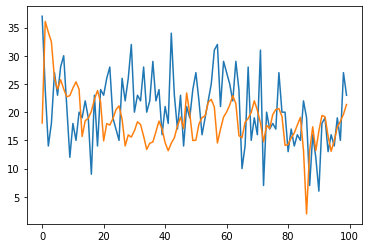

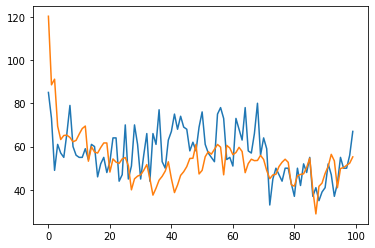

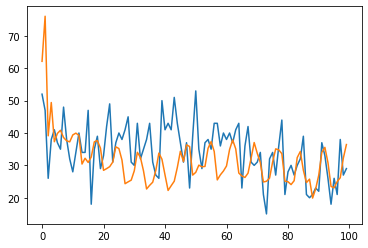

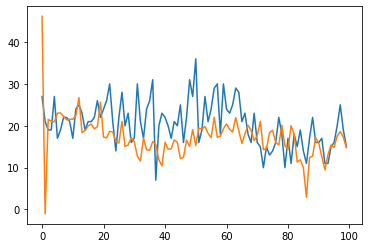

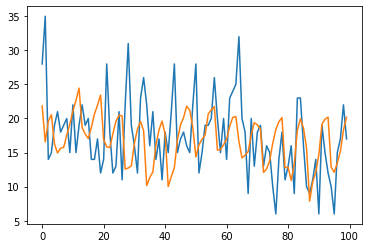

In [14]:
for i in range(5):
  item_1 = var[-100:]
  item_1_hat = [x[i] for x in predictions]
  plt.figure()
  plt.plot(item_1[:, i])
  plt.plot(item_1_hat)
  plt.show()

In [ ]:
dat = full_data[full_data.Set == 'train']
var = dat[(dat.store == store)].drop('Set', axis = 1)
var = torch.FloatTensor([var[var.date == x].sales for x in np.unique(var.date)])
test_seq = var[-TRAIN_WINDOW:]
model.eval()
predictions = []
for i in range(90):
  seq = torch.FloatTensor(test_seq[-TRAIN_WINDOW:]).cuda()
  with torch.no_grad():
    model.hidden = (torch.zeros(NUM_LAYERS,1, model.hidden_layer_size).cuda(),
                    torch.zeros(NUM_LAYERS,1, model.hidden_layer_size).cuda())
    test_seq = torch.cat((test_seq,model(seq).cpu().view(1,-1)), 0)
    y_hat = scaler1.inverse_transform(np.array(model(seq).detach().cpu()).reshape(-1,1)).reshape(-1)
    predictions.append(y_hat)

In [ ]:
start_date = pd.to_datetime('2018-1-1')
curr_date = start_date - timedelta(days=1)
total_df = pd.DataFrame(columns=['sales', 'date'])
for day_num, items in enumerate(predictions):
  curr_date = curr_date + timedelta(days=1)
  df = pd.DataFrame(predictions[1], columns=['sales'], index = range(0 + day_num,45000 + day_num, 900))
  df['date'] = curr_date
  total_df = pd.concat([total_df, df])

new_df = total_df.copy()
for i in range(9):
  new_df.index = new_df.index + 90
  total_df = pd.concat([total_df, new_df])
total_df.sort_index()


,sales,date
0,102.519585,2018-01-01
1,102.519585,2018-01-02
2,102.519585,2018-01-03
3,102.519585,2018-01-04
4,102.519585,2018-01-05
...,...,...
44995,271.875824,2018-03-27
44996,271.875824,2018-03-28
44997,271.875824,2018-03-29
44998,271.875824,2018-03-30


In [ ]:
output = total_df.drop('date', axis = 1, inplace = False)
output['id'] = total_df.index
output.to_csv('./first_try.csv')